In [2]:
from PIL import Image
from lang_sam import LangSAM

model = LangSAM("vit_b", "/home/kandelaki/git/SAM-Adapter-PyTorch/pretrained/sam_vit_b_01ec64.pth")
image_pil = Image.open("/home/kandelaki/git/SAM-Adapter-PyTorch/load/img/test/8.png").convert("RGB")
text_prompt = "Solar Panel"
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

/home/kandelaki/miniconda3/envs/sam-adapter/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/kandelaki/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


FileNotFoundError: [Errno 2] No such file or directory: '/home/kandelaki/git/SAM-Adapter-PyTorch/load/img/test/8.png'

In [ ]:
boxes

In [3]:
from torchvision import transforms
img = transforms.ToPILImage()(masks.squeeze(0).float())
import matplotlib.pyplot as plt
plt.imshow(img)

NameError: name 'masks' is not defined

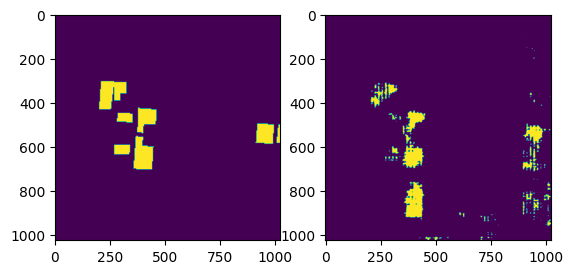

In [4]:
import torch
from torchvision import transforms
from PIL import Image
gt = torch.load("/home/kandelaki/git/SAM-Adapter-PyTorch/save/gt_0.pt")
pred = torch.load("/home/kandelaki/git/SAM-Adapter-PyTorch/save/pred_0.pt")

gt = gt.squeeze(0)
gt = gt.squeeze(0)
pred = pred.squeeze(0)
pred = pred.squeeze(0)
pred = pred > 0.5
# gt = transforms.ToPILImage()(gt.squeeze(0).float())
# pred = transforms.ToPILImage()(pred.squeeze(0).float())
gt.size()
gt_image = transforms.ToPILImage()(gt.float())
pred_imagre = transforms.ToPILImage()(pred.float())

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gt_image)
ax2.imshow(pred_imagre)
plt.show()

Text(0.5, 1.0, 'Binary Confusion Matrix Image')

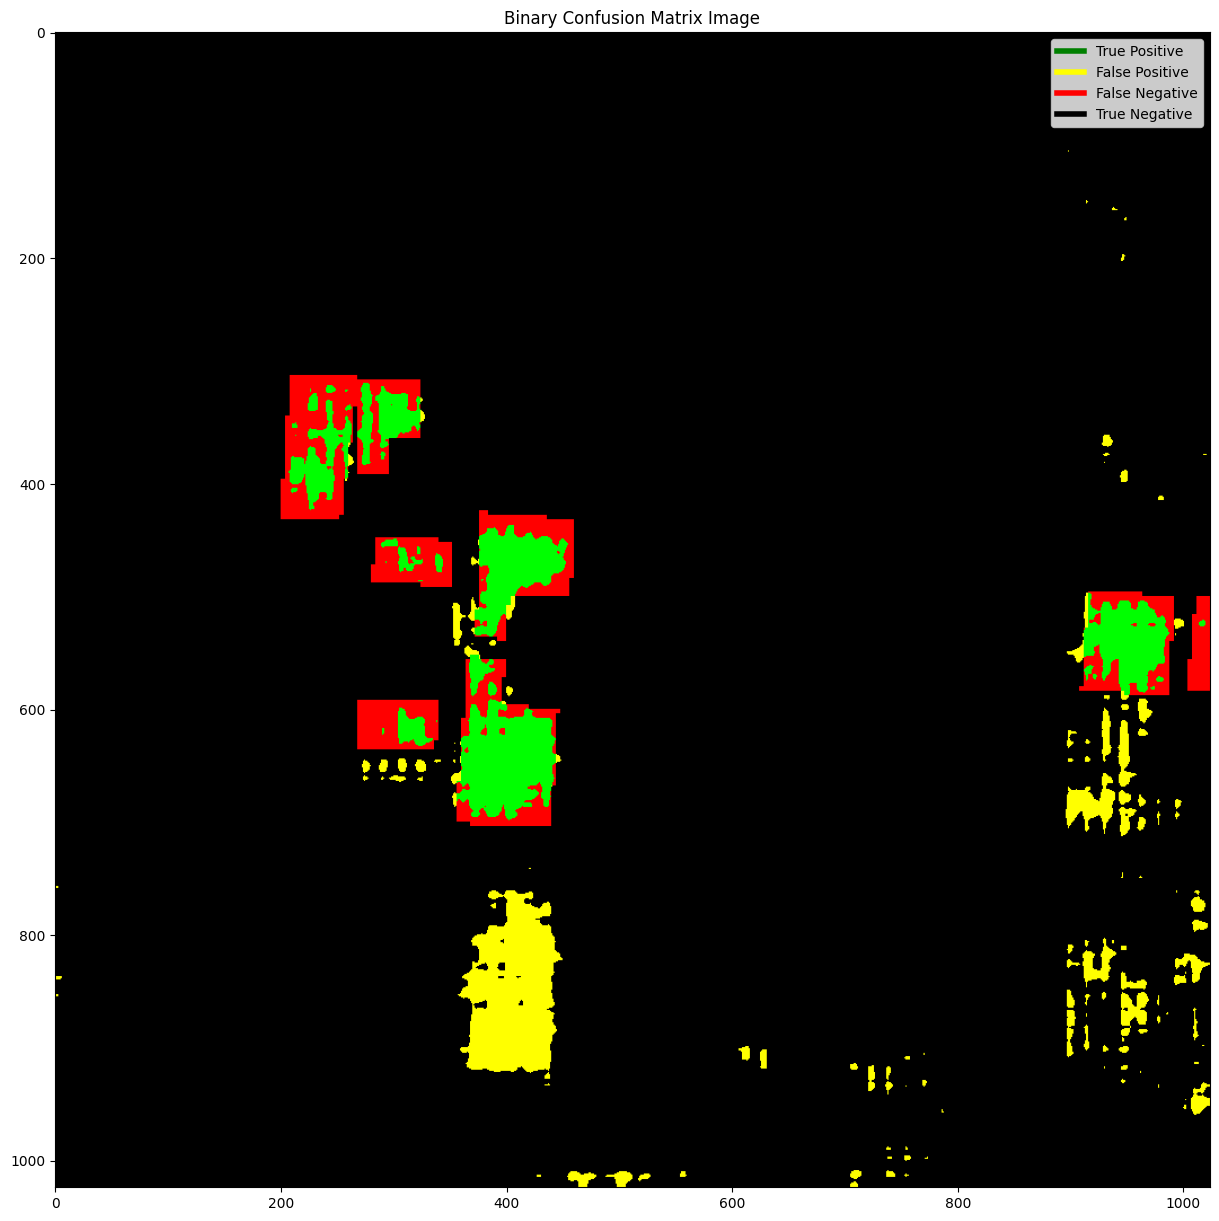

In [5]:
tp = torch.logical_and(gt, pred)
fp = torch.logical_and(torch.logical_not(gt), pred)
fn = torch.logical_and(gt, torch.logical_not(pred))
tn = torch.logical_and(torch.logical_not(gt), torch.logical_not(pred))

# create canvas
canvas = torch.zeros_like(tp)

# extent tp to 3 channels
canvas = torch.stack([canvas, canvas, canvas], dim = 0)

canvas[0][tp == 1] = 0
canvas[1][tp == 1] = 255
canvas[2][tp == 1] = 0

canvas[0][fp == 1] = 255
canvas[1][fp == 1] = 255
canvas[2][fp == 1] = 0

canvas[0][fn == 1] = 255
canvas[1][fn == 1] = 0
canvas[2][fn == 1] = 0


canvas_img = transforms.ToPILImage(mode = "RGB")(canvas.float())

fig, ax = plt.subplots(1, 1)
fig.set_figheight(15)
fig.set_figwidth(15)
        # Create Legend for the figure 
legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label='True Positive'),
                            plt.Line2D([0], [0], color='yellow', lw=4, label='False Positive'),
                            plt.Line2D([0], [0], color='red', lw=4, label='False Negative'),
                            plt.Line2D([0], [0], color='black', lw=4, label='True Negative')]
ax.legend(handles=legend_elements, loc='upper right')
ax.imshow(canvas_img)
ax.set_title('Binary Confusion Matrix Image')

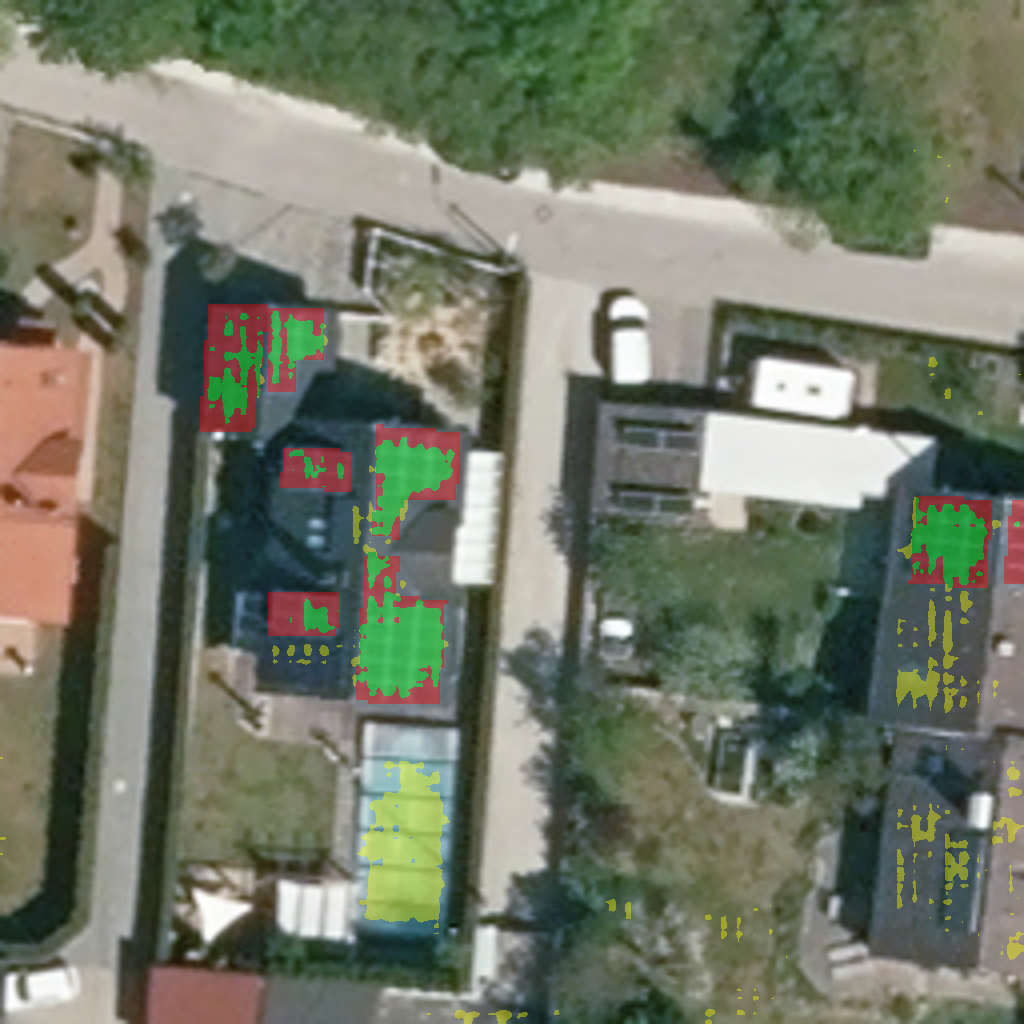

In [20]:
# overlay canvas on image
from PIL import Image
image = Image.open("/home/kandelaki/bt/data_20/preprocessed/256/load/img/eval/0.png").convert("RGBA")
image = image.resize((1024, 1024))

image_tensor = transforms.ToTensor()(image)

canvas_image = transforms.ToPILImage()(canvas)
canvas_image = canvas_image.convert("RGBA")

blended = Image.blend(image, canvas_image, alpha = 0.4)

blended_tensor = transforms.ToTensor()(blended)

canvas = canvas.float()
blended_tensor[0][tn == 1] = image_tensor[0][tn == 1]
blended_tensor[1][tn == 1] = image_tensor[1][tn == 1]
blended_tensor[2][tn == 1] = image_tensor[2][tn == 1]

blended = transforms.ToPILImage()(blended_tensor)

blended.show()


In [ ]:
def create_overlay_mask_figure(image, pred, gt, metrics, threshold=0.5):
        # remove batch dimension
        # image = image.squeeze(0)
        #pred = pred.squeeze(0)
        #pred = pred.squeeze(0)
        current_dice, mean_dice = metrics["DiceCoefficient"]
        current_jaccard, mean_jaccard = metrics["JaccardIndex"]
        
        # Image with ground truth mask
        image_gt = torch.clone(image)
       # gt = gt.squeeze(0)
       # gt = gt.squeeze(0)

        image_gt[0][gt] = 0
        image_gt[1][gt] = 1
        image_gt[2][gt] = 0
       
        pred = pred > threshold
        # Set pixels where mask is true to red
        image[0][pred] = 1
        image[1][pred] = 0
        image[2][pred] = 0


        image = transforms.ToPILImage()(image.float())
        image_gt = transforms.ToPILImage()(image_gt.float())

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_figheight(15)
        fig.set_figwidth(15)
        ax1.imshow(image_gt)
        ax1.set_title('Ground Truth Overlay')
        ax2.imshow(image)
        ax2.set_title('Prediction Overlay')
        return fig
    
def create_binary_confusion_matrix_tensor(pred, gt, threshold=0.5):
        gt = gt.squeeze(0)
        gt = gt.squeeze(0)
        pred = pred.squeeze(0)
        pred = pred.squeeze(0)
        pred = pred > threshold

        tp = torch.logical_and(gt, pred)
        fp = torch.logical_and(torch.logical_not(gt), pred)
        fn = torch.logical_and(gt, torch.logical_not(pred))
        # create canvas
        canvas = torch.zeros_like(tp)

        # extent tp to 3 channels
        canvas = torch.stack([canvas, canvas, canvas], dim = 0)

        # set tp to green
        canvas[0][tp == 1] = 0
        canvas[1][tp == 1] = 255
        canvas[2][tp == 1] = 0
        # set fp to yellow
        canvas[0][fp == 1] = 255
        canvas[1][fp == 1] = 255
        canvas[2][fp == 1] = 0
        # set fn to red
        canvas[0][fn == 1] = 255
        canvas[1][fn == 1] = 0
        canvas[2][fn == 1] = 0
        # tn are black by default
        
        return canvas

In [ ]:
image = Image.open("/home/kandelaki/bt/data_20/preprocessed/256/load/img/eval/0.png").convert("RGB")
image = image.resize((1024, 1024))

image_tensor = transforms.ToTensor()(image)

canvas = create_binary_confusion_matrix_tensor(pred, gt)

canvas = canvas.float()
image_tensor[0][tn == 0] = canvas[0][tn == 0]
image_tensor[1][tn == 0] = canvas[1][tn == 0]
image_tensor[2][tn == 0] = canvas[2][tn == 0]


canvas = transforms.ToPILImage()(image_tensor)
# create figure out of canvas
fig, ax = plt.subplots(1, 1)
fig.set_figheight(15)
fig.set_figwidth(15)
# Create Legend for the figure 
legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label='True Positive'),
                            plt.Line2D([0], [0], color='yellow', lw=4, label='False Positive'),
                            plt.Line2D([0], [0], color='red', lw=4, label='False Negative'),
                            plt.Line2D([0], [0], color='black', lw=4, label='True Negative')]
ax.legend(handles=legend_elements, loc='upper right')
ax.imshow(canvas)
ax.set_title('Overlay Confusion Matrix Image')


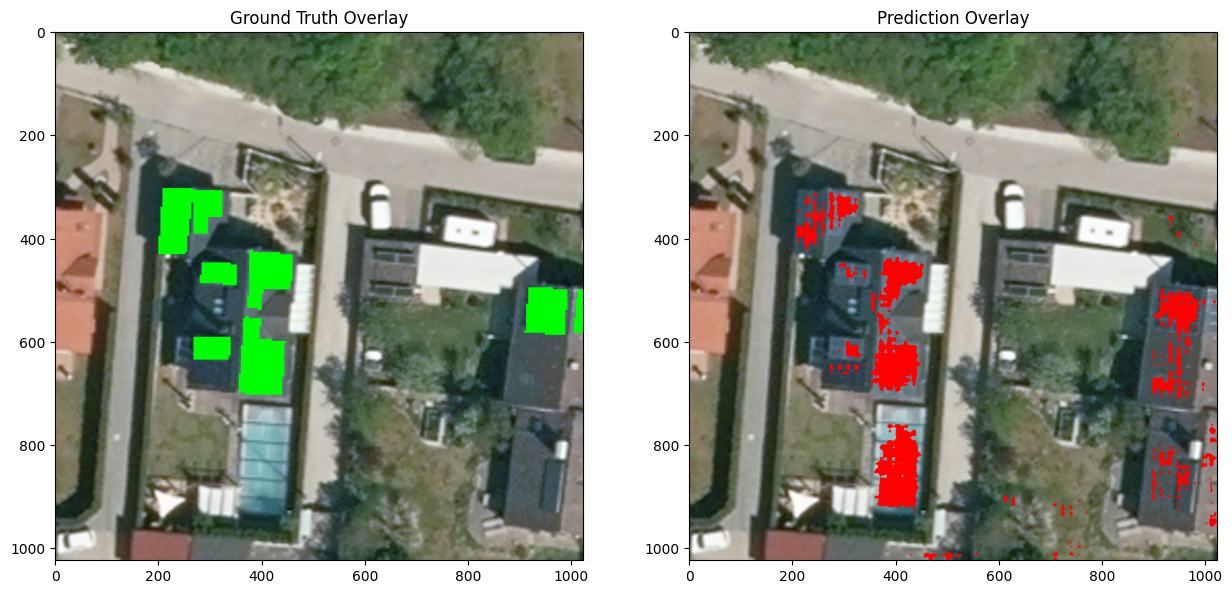

In [ ]:
tens = transforms.ToTensor()(image)
fig = create_overlay_mask_figure(tens, pred, gt)
fig.show()